In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision import transforms
import random

In [3]:
import numpy 
numpy.__version__

'2.1.1'

# Creating a generator

In [4]:
import torch.nn as nn

# Set a seed

latent_dim = 100
class Generator(nn.Module):
    def block(self,ip_features,op_features,normalize=True):
            layers = [nn.Linear(ip_features,op_features)]
            if normalize:
                layers.append(nn.BatchNorm1d(op_features,0.8))
            layers.append(nn.LeakyReLU(0.2,inplace=True))    
            return layers
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            *self.block(latent_dim,128,False),
            *self.block(128,256),
            *self.block(256,512),
            *self.block(512,1024),
            nn.Linear(1024,1*28*28),
            nn.Tanh()
        )
    def forward(self,z):
            img = self.model(z)
            img = img.view(img.size(0),1,28,28)
            return img


# create a discriminator

In [5]:
class Discriminator(nn.Module):
    def block(self,ip,op):
        layers = [nn.Linear(ip,op),
            nn.LeakyReLU(0.2,inplace=True),
        ]
        return layers
    def __init__(self):
        super(Discriminator,self).__init__()
        self.model =  nn.Sequential(
            *self.block(1*28*28,512),
            *self.block(512,256),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    def forward(self,z):
        img = z.view(z.size(0),-1)
        op =  self.model(img)
        return op   

In [6]:
# adversarial loss would be binary cross entropy

adversarial_loss = nn.BCELoss()

In [7]:
gen = Generator()
disc = Discriminator()

In [8]:
disc.to('cuda')

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [9]:
gen.to('cuda')

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

# switching to GPU

# training the model

In [1]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.optim as opt
import numpy as np

# hyperparameters
n_epochs = 100
batch_size = 64
lr = 2e-4
b1=0.5
b2=0.999

In [ ]:
# use adam for generator and discriminator
opt_g = opt.Adam(gen.parameters(),lr,betas=(b1,b2))
opt_d = opt.Adam(disc.parameters(),lr,betas=(b1,b2))

In [24]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
train_dataset = MNIST(root='./mnist_data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

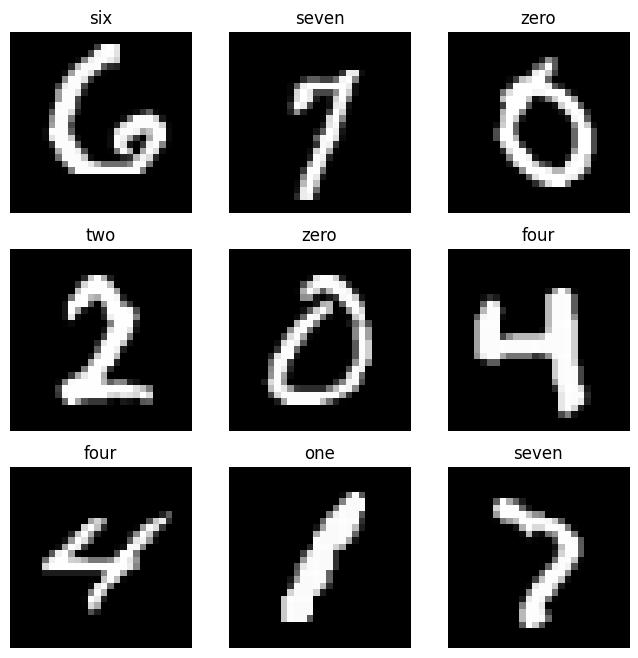

In [25]:
import matplotlib.pyplot as plt
labels_map = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [26]:
# Training loop
for epoch in range(n_epochs):
    for batch_idx, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to('cuda')
        current_batch_size = real_images.size(0)
        
        # Real and fake labels
        real_labels = torch.ones(current_batch_size, 1).to('cuda')
        fake_labels = torch.zeros(current_batch_size, 1).to('cuda')
        
        # Train Discriminator
        opt_d.zero_grad()
        
        z = torch.randn(current_batch_size, latent_dim).to('cuda')
        fake_images = gen(z)
        
        D_real = disc(real_images)
        D_fake = disc(fake_images.detach())
        
        real_loss = adversarial_loss(D_real, real_labels)
        fake_loss = adversarial_loss(D_fake, fake_labels)
        
        D_loss = real_loss + fake_loss
        D_loss.backward()
        opt_d.step()
        
        # Train Generator
        opt_g.zero_grad()
        
        z = torch.randn(current_batch_size, latent_dim).to('cuda')
        fake_images = gen(z)
        D_fake = disc(fake_images)
        
        G_loss = adversarial_loss(D_fake, real_labels)
        G_loss.backward()
        opt_g.step()
    
    print(f"Epoch [{epoch+1}/{n_epochs}] | D Loss: {D_loss.item():.4f} | G Loss: {G_loss.item():.4f}")

Epoch [1/100] | D Loss: 0.6991 | G Loss: 1.6599
Epoch [2/100] | D Loss: 0.7908 | G Loss: 1.7537
Epoch [3/100] | D Loss: 0.9325 | G Loss: 1.1137
Epoch [4/100] | D Loss: 0.8840 | G Loss: 1.7196
Epoch [5/100] | D Loss: 0.8303 | G Loss: 1.2864
Epoch [6/100] | D Loss: 0.8079 | G Loss: 1.3648
Epoch [7/100] | D Loss: 0.9626 | G Loss: 1.3448
Epoch [8/100] | D Loss: 0.9634 | G Loss: 1.2444
Epoch [9/100] | D Loss: 1.0952 | G Loss: 1.9536
Epoch [10/100] | D Loss: 1.0222 | G Loss: 0.7585
Epoch [11/100] | D Loss: 1.1774 | G Loss: 1.5583
Epoch [12/100] | D Loss: 1.0020 | G Loss: 1.4576
Epoch [13/100] | D Loss: 0.8925 | G Loss: 1.9150
Epoch [14/100] | D Loss: 0.9559 | G Loss: 1.0736
Epoch [15/100] | D Loss: 0.8857 | G Loss: 1.5436
Epoch [16/100] | D Loss: 1.1216 | G Loss: 1.6143
Epoch [17/100] | D Loss: 0.7969 | G Loss: 1.4302
Epoch [18/100] | D Loss: 0.9222 | G Loss: 2.6337
Epoch [19/100] | D Loss: 1.0477 | G Loss: 2.5258
Epoch [20/100] | D Loss: 0.9322 | G Loss: 1.0019
Epoch [21/100] | D Loss: 0.88

In [32]:
# Generate and save sample images
with torch.no_grad():
    z = torch.randn(16, latent_dim).to('cuda')
    sample_images = gen(z)
    sample_images = sample_images.cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i, 0], cmap='gray')
    ax.axis('off')
plt.savefig('gan_samples.png')
plt.close()

print("Training completed. Sample images saved as 'gan_samples.png'.")

Training completed. Sample images saved as 'gan_samples.png'.


In [33]:
torch.save(gen,f='./GAN weights/generator.pt')

In [34]:
torch.save(disc,f='./GAN weights/discriminator.pt')